$$
f(x) = x^2 + 3x + 1
$$

$$
\hat{f}(x) = f(x_0) + f^\prime(x_0)(x - x_0)
$$

In [1]:
import numpy as np

def f(x):
  return x**2 + 3*x + 1

x0 = 2
f_x0 = f(x0)
df_dx = 2*x0 + 3

def affine_approx(x):
  return f_x0 + df_dx * (x - x0)

x_eval = 2.5
approx_val = affine_approx(x_eval)
true_val = f(x_eval)
diff = true_val - approx_val

print(f"Affine approximation at {x_eval}: {approx_val}")
print(f"True value at {x_eval}: {true_val}")
print(f"Difference: {diff}")

Affine approximation at 2.5: 14.5
True value at 2.5: 14.75
Difference: 0.25


$$
a = [1, 2, 3] \quad b = [4, 5, 6]
$$

In [8]:
import numpy as np

a = np.array([1, 2, 3])
b = np.array([4, 5, 6])

norm_a = np.linalg.norm(a)
dist = np.linalg.norm(a - b)
dot_product = np.dot(a, b)
norm_b = np.linalg.norm(b)
angle_rad = np.arccos(dot_product/(norm_a * norm_b))
angle_deg = np.degrees(angle_rad)
std_a = np.std(a)

print(f"Euclidean norm of a: {norm_a}")
print(f"Distance between a and b: {dist}")
print(f"Angle between a and b (degrees): {angle_deg}")
print(f"Standard deviation of a: {std_a}")

Euclidean norm of a: 3.7416573867739413
Distance between a and b: 5.196152422706632
Angle between a and b (degrees): 12.933154491899135
Standard deviation of a: 0.816496580927726


$$
v_1 = [1, 0, 0] \quad v_2 = [1, 1, 0] \quad v_3 = [1, 1, 1]
$$

In [ ]:
import numpy as np

v1 = np.array([1, 0, 0])
v2 = np.array([1, 1, 0])
v3 = np.array([1, 1, 1])
V = np.column_stack([v1, v2, v3])

independent = np.linalg.matrix_rank(V) == V.shape[1]

Q = np.zeros_like(V, dtype=float)
Q[:, 0] = v1 / np.linalg.norm(v1)
u2 = v2 - np.dot(v2, Q[:, 0]) * Q[:, 0]


[0. 1. 0.]


Missile hit target at t=1.48s, position: (9.16, 4.58)


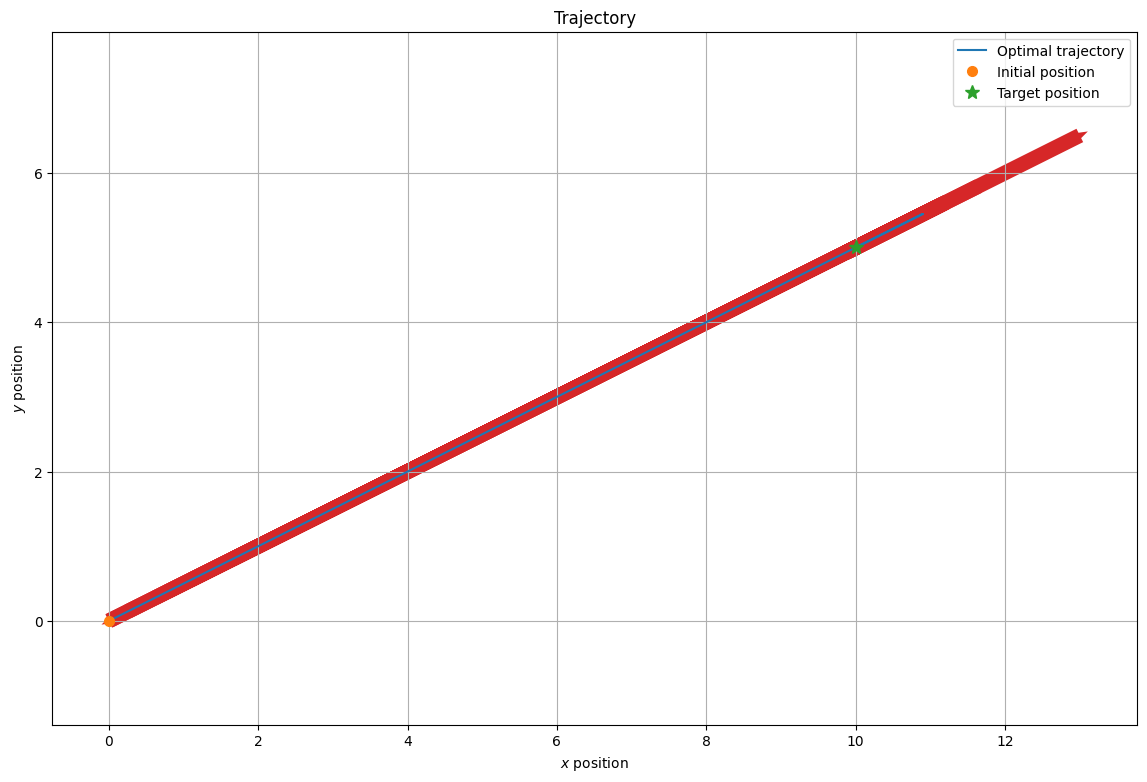

Final position: (10.00, 5.00)
Target: (10, 5)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 시스템 파라미터
dt = 0.01  # 타임 스텝
t_max = 10  # 총 시간
steps = int(t_max / dt)

# 상태 공간 모델
A = np.array([[0, 0, 1, 0],
              [0, 0, 0, 1],
              [0, 0, 0, 0],
              [0, 0, 0, 0]])
B = np.array([[0, 0],
              [0, 0],
              [1, 0],
              [0, 1]])

# 초기 상태
z0 = np.array([0, 0, 4, 1])  # [x, y, v_x, v_y]
z = z0.copy()
trajectory = np.zeros((steps + 1, 2))  # [x, y] 저장
trajectory[0] = z[:2]
control_vectors = []  # changed to store control_vec arrays
control_magnitudes = []  # u의 절댓값
control_inputs = []  # u 벡터 저장
hit = False
post_hit_steps = 0  # 원본에서 0, 확장 로직 없음

# 목표 상태
z_target = np.array([10, 5, 0, 0])

# 제어 게인 (2x4로 보정, 독립 제어)
K = np.array([[1.5, 1.5, 2.0, 2.0]])  # y, v_y 보정

i = 0
while i < steps + post_hit_steps:
    # 제어 입력 (2D 벡터)
    error = z - z_target
    u = -np.dot(K, error)  # 2x1 벡터
    if hit:
        u *= 2.0  # 히트 후 강한 제어
    control_inputs.append(u.copy())
    u_scalar = np.linalg.norm(u)  # 스칼라로 변환
    control_magnitudes.append(u_scalar)
    
    # 힘 방향 (가속 변화) - delta v = dt * u
    control_vec = dt * np.dot(B, u).flatten()  # 4x1 -> flatten
    control_vectors.append(control_vec.copy())  # FIXED HERE
    
    # 상태 업데이트
    z_dot = np.dot(A, z) + np.dot(B, u)
    z = z + dt * z_dot
    
    # 종료 조건 및 뒤로 돌아가기 로직
    dist = float(np.linalg.norm(z[:2] - z_target[:2]))
    if dist < 1 and not hit:
        hit = True
        print(f"Missile hit target at t={(i+1) * dt:.2f}s, position: ({z[0]:.2f}, {z[1]:.2f})")
    elif hit and i < steps + post_hit_steps:
        if dist > 1.0:
            z[2:] = -z[2:] * 0.5
            # u 재계산 불필요 (이미 다음 스텝에서 hit 적용)
    elif i >= steps + post_hit_steps:
        break
    
    trajectory[i + 1] = z[:2]
    if i == steps - 1 and not hit:
        print("Missile missed target!")
    i += 1

# 화살표 길이 정규화
# max_magnitude = max(control_magnitudes) if control_magnitudes else 1.0
# scale_factor = 2.0 / max_magnitude if max_magnitude > 0 else 1.0

# 10스텝 구간의 누적 합력 계산 (u_opt 대체)
# 원본 의도대로 delta v 기반, 하지만 독립 ux, uy 적용
u_opt = np.array([control_vec[2:].flatten() for control_vec in control_vectors]).T  # 2xN 배열 (delta v_x, delta v_y)

# 시각화
plt.figure(figsize=(14, 9), dpi=100)
plt.plot(trajectory[:, 0], trajectory[:, 1], label='Optimal trajectory')
plt.plot(z0[0], z0[1], 'o', markersize=10, label='Initial position')
plt.plot(z_target[0], z_target[1], '*', markersize=10, label='Target position')
plt.title('Trajectory')
plt.legend()

# 화살표 표현 (제어 벡터 기반) - scale_factor 적용
N = len(trajectory)
for j in range(0, N-1, 10):
    # scaled_dx = scale_factor * 10 * u_opt[0, j]
    # scaled_dy = scale_factor * 10 * u_opt[1, j]
    plt.arrow(trajectory[j, 0], trajectory[j, 1], 10*u_opt[0, j], 10*u_opt[1, j],
              head_width=0.08, width=0.03, fc='tab:red', ec='none', label='Control Vector' if j == 0 else "")

plt.axis('equal')
plt.xlabel(r'$x$ position')
plt.ylabel(r'$y$ position')
plt.grid()
plt.show()

# 최종 위치 출력
final_pos = trajectory[-1]
print(f"Final position: ({final_pos[0]:.2f}, {final_pos[1]:.2f})")
print(f"Target: (10, 5)")

Missile missed target!


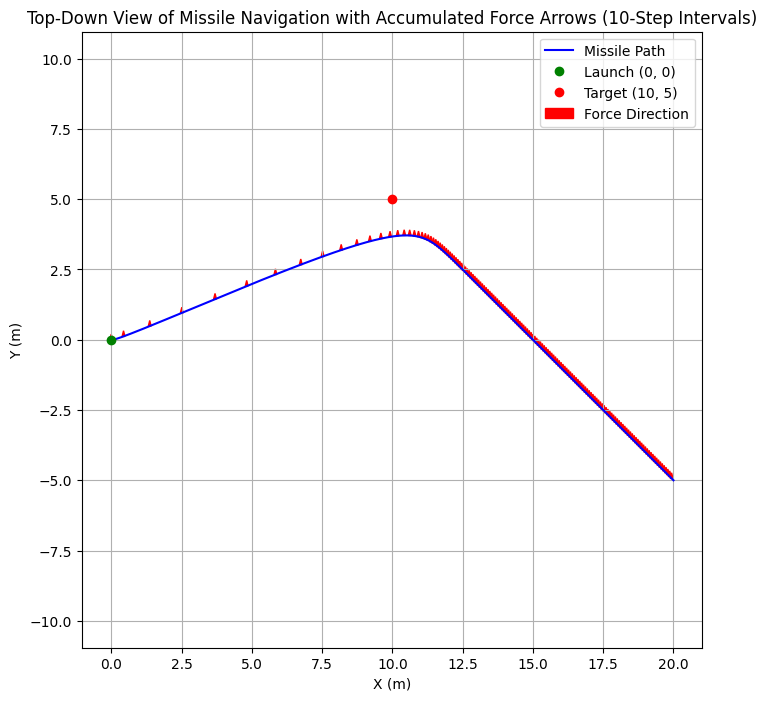

Final position: (20.00, -5.00)
Target: (10, 5)


In [72]:
import numpy as np
import matplotlib.pyplot as plt

# 시스템 파라미터
dt = 0.01  # 타임 스텝
t_max = 15   # 총 시간 (증가)
steps = int(t_max / dt)

# 상태 공간 모델
A = np.array([[0, 0, 1, 0],
              [0, 0, 0, 1],
              [0, 0, 0, 0],
              [0, 0, 0, 0]])
B = np.array([[0], [0], [2], [1]])  # 4x1 벡터

# 초기 상태
z0 = np.array([0, 0, 1, -0.5])  # [x, y, v_x, v_y] 초기 속도 목표 방향에 가깝게 조정
z_target = np.array([10, 5, 0, 0])

# 제어 게인 (보정 강도 증가)
K = np.array([3.0, 3.0, 2.0, 2.0])  # v_x, v_y 보정 강화

# 시뮬레이션
z = z0.copy()
trajectory = np.zeros((steps + 1, 2))  # 크기 조정: steps + 1
trajectory[0] = z[:2]
control_vectors = []  # (start, end) 튜플
control_magnitudes = []  # u의 절댓값
hit = False

for i in range(steps):
    # 제어 입력 (스칼라로 변환)
    error = z - z_target
    u = float(-np.dot(K, error))  # 스칼라로 명시적 변환
    control_magnitudes.append(abs(u))
    
    # 힘 방향 (가속 변화)
    control_vec = dt * B * u  # 4x1 벡터
    control_vectors.append((z[:2].copy(), (z[:2] + control_vec[:2].flatten()).copy()))
    
    # 상태 업데이트
    z_dot = A @ z + B.flatten() * u  # B를 1D로 변환 후 스칼라 곱
    z = z + dt * z_dot.flatten()  # z를 1D로 유지
    
    # 히트 체크
    dist = np.linalg.norm(z[:2] - z_target[:2])
    if dist < 0.5 and not hit:
        hit = True
        print(f"Missile hit target at t={(i+1) * dt:.2f}s, position: ({z[0]:.2f}, {z[1]:.2f})")
    
    trajectory[i + 1] = z[:2]

    if i == steps - 1 and not hit:
        print("Missile missed target!")

# 화살표 길이 정규화
max_magnitude = max(control_magnitudes) if control_magnitudes else 1.0
scale_factor = 2.0 / max_magnitude if max_magnitude > 0 else 1.0

# 10스텝 구간의 누적 합력 계산
arrow_interval = 10
sum_control_vectors = []
sum_control_magnitudes = []
for i in range(0, len(control_vectors), arrow_interval):
    segment_vectors = control_vectors[i:i + arrow_interval]
    segment_magnitudes = control_magnitudes[i:i + arrow_interval]
    
    if segment_vectors:
        start_point = segment_vectors[0][0]
        vector_diffs = np.array([end - start for start, end in segment_vectors])
        sum_diff = np.sum(vector_diffs, axis=0)
        sum_magnitude = np.sum(segment_magnitudes)
        
        sum_control_vectors.append((start_point, start_point + sum_diff))
        sum_control_magnitudes.append(sum_magnitude)

# 시각화
plt.figure(figsize=(8, 8))
end_i = steps if not hit else i + 1
plt.plot(trajectory[:end_i + 1, 0], trajectory[:end_i + 1, 1], 'b-', label='Missile Path')
plt.plot(z0[0], z0[1], 'go', label='Launch (0, 0)')
plt.plot(z_target[0], z_target[1], 'ro', label='Target (10, 5)')
if hit:
    plt.plot(z[0], z[1], 'kx', markersize=10, label='Explosion')

# 누적 합력 화살표
label_added = False
for (start, end), mag in zip(sum_control_vectors, sum_control_magnitudes):
    dx = (end[0] - start[0]) * scale_factor * (mag / max_magnitude)
    dy = (end[1] - start[1]) * scale_factor * (mag / max_magnitude)
    plt.arrow(start[0], start[1], dx, dy,
              head_width=0.1, head_length=0.2, fc='r', ec='r',
              label='Force Direction' if not label_added else "")
    label_added = True

plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.title('Top-Down View of Missile Navigation with Accumulated Force Arrows (10-Step Intervals)')
plt.grid()
plt.legend()
plt.axis('equal')
plt.show()

# 최종 위치 출력
final_pos = trajectory[end_i] if end_i < len(trajectory) else trajectory[-1]
print(f"Final position: ({final_pos[0]:.2f}, {final_pos[1]:.2f})")
print(f"Target: (10, 5)")

--- Generating Final Static Analysis Plot ---


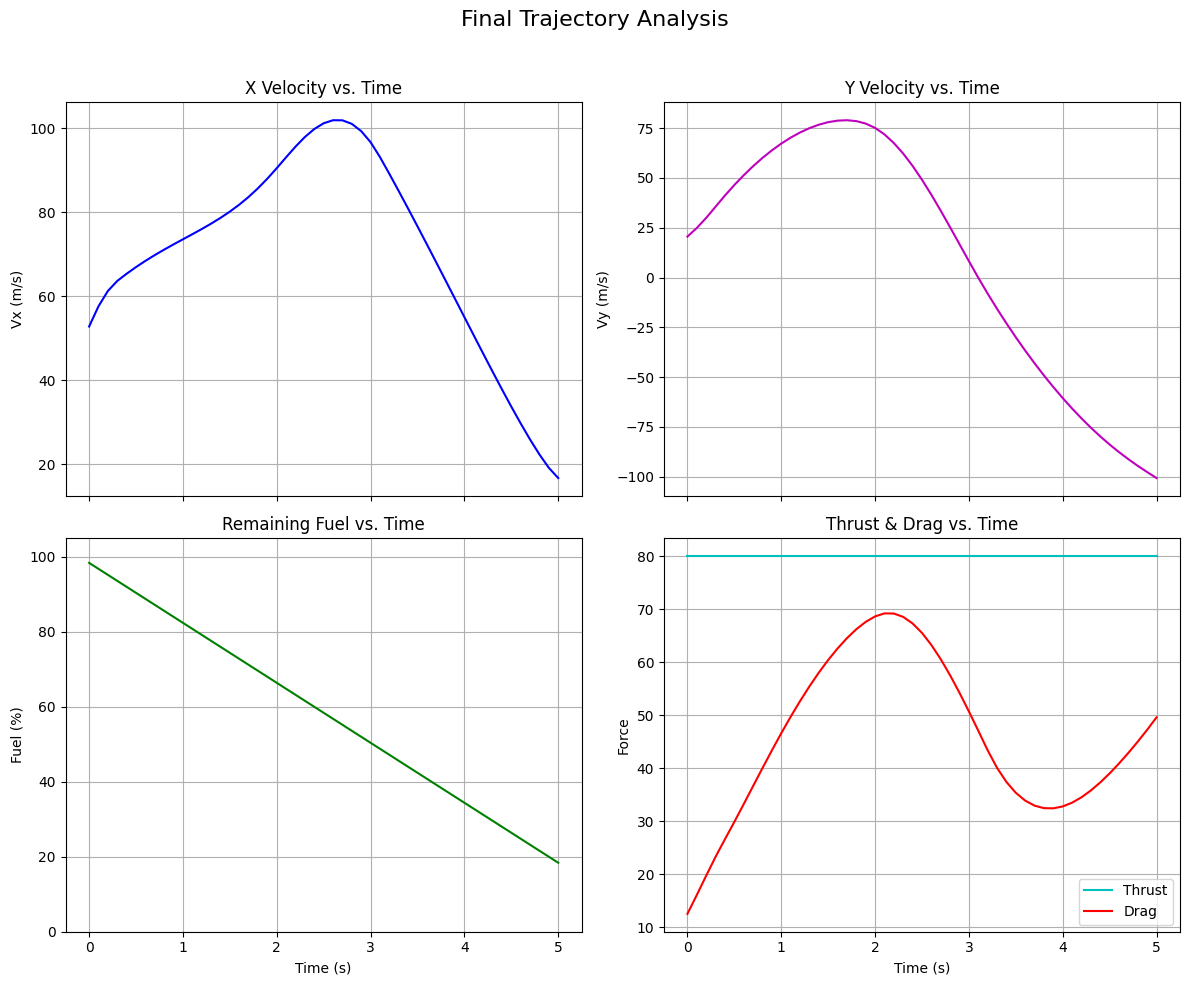


--- Generating Animation ---


In [79]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Wedge, Rectangle
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display
import matplotlib.transforms as transforms

# 노트북 환경에서 포함되는 애니메이션의 용량 제한을 늘립니다.
matplotlib.rcParams['animation.embed_limit'] = 50.0

# --- 1. 시뮬레이션 환경 및 파라미터 정의 ---

# 초기 조건
my_position = np.array([0, 0])  # 미사일 발사대의 시작 위치
initial_target_position = np.array([100, 200])  # 목표물의 초기 위치
target_velocity = np.array([50.0, -30.0])  # 목표물의 등속도 벡터

# 센서/무장 파라미터
radius = 130  # 센서 또는 교전 구역의 시각적 반경
theta_start_deg = -30  # 시각적 섹터의 시작 각도
theta_end_deg = 60  # 시각적 섹터의 끝 각도

# 미사일 속성
missile_sigma = 40.0  # 폭발의 가우시안 히트맵을 위한 표준 편차 (폭발 반경)
missile_width = 2  # 미사일의 시각적 너비
missile_height = 7  # 미사일의 시각적 높이
initial_angle_deg = 20.0  # 미사일의 초기 발사 각도
initial_speed = 50.0  # 미사일의 초기 속도
thrust_force = 80.0  # 엔진이 켜졌을 때의 일정한 추력
drag_coefficient = 0.005  # 단순화된 항력 계수
fuel = 100.0  # 초기 연료량
fuel_consumption_rate = 0.2  # 추력 단위당 연료 소모율
mass = 1.0  # 미사일의 질량
max_turn_rate_dps = 90.0  # 초당 최대 선회율 (도)

# 시뮬레이션 제어
max_frames = 100  # 시뮬레이션의 최대 스텝 수
explosion_frames = 50 # 폭발 애니메이션이 지속될 프레임 수
dt = 0.1  # 시뮬레이션 시간 간격 (초)

# --- [수정된 부분] 플롯 범위 변수 ---
# 여기를 수정하여 모든 그래프의 X, Y축 범위를 조절할 수 있습니다.
plot_x_lim = (-50, 400)
plot_y_lim = (-50, 400)
# -----------------------------------


# --- 2. 동역학 시뮬레이션 실행 및 데이터 저장 ---

# 나중에 플로팅하기 위해 변수 기록을 저장할 리스트들
path_history, target_path_history, angle_history, velocity_history, fuel_history, thrust_history, drag_history = [], [], [], [], [], [], []

# 미사일 상태 변수 초기화
missile_pos = np.copy(my_position).astype(float)
missile_angle_rad = np.deg2rad(initial_angle_deg)
missile_vel = np.array([initial_speed * np.cos(missile_angle_rad), initial_speed * np.sin(missile_angle_rad)])
target_pos = np.copy(initial_target_position).astype(float)
current_fuel = fuel

# 메인 시뮬레이션 루프
for frame in range(max_frames):
    # 목표물의 등속도에 기반하여 위치 업데이트
    target_pos += target_velocity * dt

    # 미사일에서 목표물까지의 벡터 계산 (시선 벡터)
    vec_to_target = target_pos - missile_pos

    # 미사일이 목표물에 충분히 가까워지면 비행 단계 종료
    if np.linalg.norm(vec_to_target) < 10:
        break

    # --- 유도 법칙 (비례 항법) ---
    # 목표물을 직접 향하기 위해 필요한 각도 계산
    target_angle_rad = np.arctan2(vec_to_target[1], vec_to_target[0])

    # 미사일의 현재 각도와 목표 각도 사이의 오차 계산
    angle_error = target_angle_rad - missile_angle_rad

    # 최단 거리 회전을 위해 각도 오차를 [-pi, pi] 범위로 정규화
    angle_error = (angle_error + np.pi) % (2 * np.pi) - np.pi

    # 현재 시간 간격(dt) 동안 미사일이 선회할 수 있는 최대 각도 계산
    turn_rate_rad = np.deg2rad(max_turn_rate_dps)

    # 선회량을 미사일의 물리적 최대 선회율로 제한
    turn_amount = np.clip(angle_error, -turn_rate_rad * dt, turn_rate_rad * dt)

    # --- 추진 및 연료 ---
    current_thrust = 0
    # 연료가 남아있을 경우에만 추력을 가하고 선회
    if current_fuel > 0:
        # 미사일의 각도 업데이트
        missile_angle_rad += turn_amount
        # 추력을 최대값으로 설정
        current_thrust = thrust_force
        # 추력과 시간에 기반하여 연료 소모
        fuel_consumed = thrust_force * fuel_consumption_rate * dt
        current_fuel = max(0, current_fuel - fuel_consumed)

    # --- 동역학 (뉴턴의 제2법칙 & 오일러 적분) ---
    # 미사일의 현재 각도에 기반한 추력 벡터 계산
    thrust_vec = np.array([np.cos(missile_angle_rad), np.sin(missile_angle_rad)]) * current_thrust

    # 항력 계산 (단순화된 모델: F_drag = -k * |v| * v)
    current_speed = np.linalg.norm(missile_vel)
    drag_vec = -drag_coefficient * current_speed * missile_vel

    # 미사일에 작용하는 모든 힘을 합산
    total_force = thrust_vec + drag_vec

    # 뉴턴의 제2법칙(a = F/m)을 사용하여 가속도 계산
    acceleration = total_force / mass

    # 오일러 적분을 사용하여 속도 및 위치 업데이트
    missile_vel += acceleration * dt
    missile_pos += missile_vel * dt

    # 현재 상태 변수들을 각각의 기록 리스트에 저장
    path_history.append(np.copy(missile_pos)); target_path_history.append(np.copy(target_pos)); angle_history.append(missile_angle_rad)
    velocity_history.append(np.copy(missile_vel)); fuel_history.append(current_fuel); thrust_history.append(current_thrust)
    drag_history.append(np.linalg.norm(drag_vec))

# --- 플로팅을 위한 데이터 처리 ---
flight_frames = len(path_history) # 비행이 지속된 총 프레임 수
path_arr = np.array(path_history); target_path_arr = np.array(target_path_history)
vel_arr = np.array(velocity_history)
vx_history = vel_arr[:, 0]; vy_history = vel_arr[:, 1]
t_path = np.arange(flight_frames) * dt # 플롯을 위한 시간 축 생성


# --- 3. 정적 분석 플롯 생성 ---
# 이 섹션은 시뮬레이션 완료 후 비행 데이터를 분석하기 위한 플롯을 생성합니다.
print("--- Generating Final Static Analysis Plot ---")
fig_analysis, axs = plt.subplots(2, 2, figsize=(12, 10), sharex=True)
fig_analysis.suptitle('Final Trajectory Analysis', fontsize=16)
axs = axs.flatten()
axs[0].plot(t_path, vx_history, 'b-'); axs[0].set_title('X Velocity vs. Time'); axs[0].set_ylabel('Vx (m/s)'); axs[0].grid(True)
axs[1].plot(t_path, vy_history, 'm-'); axs[1].set_title('Y Velocity vs. Time'); axs[1].set_ylabel('Vy (m/s)'); axs[1].grid(True)
axs[2].plot(t_path, fuel_history, 'g-'); axs[2].set_title('Remaining Fuel vs. Time'); axs[2].set_xlabel('Time (s)'); axs[2].set_ylabel('Fuel (%)'); axs[2].grid(True); axs[2].set_ylim(0, 105)
axs[3].plot(t_path, thrust_history, 'c-', label='Thrust'); axs[3].plot(t_path, drag_history, 'r-', label='Drag'); axs[3].set_title('Thrust & Drag vs. Time'); axs[3].set_xlabel('Time (s)'); axs[3].set_ylabel('Force'); axs[3].grid(True); axs[3].legend()
plt.tight_layout(rect=[0, 0, 1, 0.96]); plt.show()


# --- 4. 애니메이션 생성 ---
print("\n--- Generating Animation ---")
# 애니메이션을 위한 메인 Figure와 Axis 설정
fig_anim, ax_anim = plt.subplots(figsize=(10, 8))
ax_anim.set_title("4DOF Moving Target Interception")
ax_anim.set_xlabel("X coordinate"); ax_anim.set_ylabel("Y coordinate")
ax_anim.grid(True); ax_anim.set_aspect('equal', adjustable='box')
# 미리 정의된 플롯 범위 사용
ax_anim.set_xlim(plot_x_lim); ax_anim.set_ylim(plot_y_lim)

# 폭발 히트맵을 위한 그리드 생성
grid_x, grid_y = np.meshgrid(np.linspace(plot_x_lim[0], plot_x_lim[1], 400), np.linspace(plot_y_lim[0], plot_y_lim[1], 400))
pos_grid = np.dstack((grid_x, grid_y))

# 폭발 중심을 위한 최종 충돌 지점 계산
final_impact_point = path_arr[-1] if flight_frames > 0 else my_position

# 폭발 확률 맵을 위한 2D 가우시안 분포 생성
hit_probability = np.exp(-np.sum((pos_grid - final_impact_point)**2, axis=-1) / (2 * missile_sigma**2))

# 히트맵 이미지 객체 생성, 초기에는 투명(alpha=0)
heatmap_anim = ax_anim.imshow(hit_probability, cmap='hot', extent=[*plot_x_lim, *plot_y_lim], origin='lower', alpha=0)

# 애니메이션을 위한 정적 및 동적 플롯 객체 생성
ax_anim.plot(my_position[0], my_position[1], 'ks', ms=8, label='My Position') # 발사대
sector_anim = Wedge(my_position, radius, theta_start_deg, theta_end_deg, facecolor='none', edgecolor='gray', lw=1.5, ls='--'); ax_anim.add_patch(sector_anim) # 센서 영역
missile_patch = Rectangle((-missile_height/2, -missile_width/2), missile_height, missile_width, facecolor='orangered'); ax_anim.add_patch(missile_patch) # 미사일 본체
trajectory_line, = ax_anim.plot([], [], '--', color='orange', linewidth=2) # 미사일 경로
target_plot, = ax_anim.plot([], [], 'ro', ms=8, label='Enemy') # 목표물 마커
fuel_text = ax_anim.text(0.02, 0.95, '', transform=ax_anim.transAxes) # 연료 상태 텍스트
ax_anim.legend(loc='upper right')

# 애니메이션을 위한 메인 업데이트 함수, 각 프레임마다 호출됨
def update(frame):
    # --- 비행 단계 ---
    if frame < flight_frames:
        # 현재 프레임에 대한 데이터 가져오기
        missile_pos = path_history[frame]
        missile_angle_rad_current = angle_history[frame]
        target_pos_current = target_path_history[frame]

        # 미사일 패치를 회전하고 이동시키기 위한 변환 생성
        transform = (transforms.Affine2D().rotate(missile_angle_rad_current) +
                     transforms.Affine2D().translate(missile_pos[0], missile_pos[1]) +
                     ax_anim.transData)
        missile_patch.set_transform(transform)

        # 궤적 선과 목표물 위치 업데이트
        trajectory_line.set_data(path_arr[:frame+1, 0], path_arr[:frame+1, 1])
        target_plot.set_data([target_pos_current[0]], [target_pos_current[1]])

        # 연료 텍스트 업데이트
        fuel_text.set_text(f'Fuel: {fuel_history[frame]:.1f}%')
    # --- 폭발 단계 ---
    else:
        # 충돌 후 미사일과 목표물을 보이지 않게 처리
        missile_patch.set_visible(False)
        target_plot.set_visible(False)

        # 폭발 애니메이션 진행률 계산 (0.0에서 1.0까지)
        explosion_progress = min(1.0, (frame - flight_frames) / explosion_frames) if (frame - flight_frames) >= 0 else 0

        # 폭발 히트맵을 서서히 나타나게 함
        heatmap_anim.set_alpha(explosion_progress)

    return missile_patch, trajectory_line, target_plot, fuel_text, heatmap_anim

# 애니메이션 객체 생성
anim = FuncAnimation(fig_anim, update, frames=flight_frames + explosion_frames, interval=30, blit=True)

# 정적 플롯이 노트북에 표시되는 것을 방지하기 위해 닫음
plt.close(fig_anim)

# 애니메이션 저장 (선택 사항)
# anim.save("missile_simulation.gif", writer='imagemagick')

# 노트북 환경에서 애니메이션 표시
display(HTML(anim.to_jshtml()))
